In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [5]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4

1.15.0
2.2.4


# OmniFold Gaussian Toy Example

We will unfold the same data but with two cases:

(a) there are no generator MC weights from using simulation.

(b) there are generator MC weights from using simulation.

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

In [7]:
N = 10**6
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (1, 1.5)  # this is the data (the target)
epsilon = sigma0 / 1.  # Smearing width

theta0_G = np.random.normal(theta0_param[0], theta0_param[1],
                            N)  # Generator-level synthetic sample

# Toy MC weights from "MC sampling"
weightsMC_0 = np.array([(np.random.normal(abs(x), epsilon)) for x in theta0_G
                        ])  # Detector smearing for synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G
                     ])  # Detector smearing for synthetic sample
theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

theta_unknown_G = np.random.normal(theta_unknown_param[0],
                                   theta_unknown_param[1], N)
# Toy MC weights from "MC sampling"
weightsMC_unknown = np.array([(np.random.normal(abs(x), epsilon))
                              for x in theta_unknown_G])
# Detector smearing for synthetic sample
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon))
                            for x in theta_unknown_G])
theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

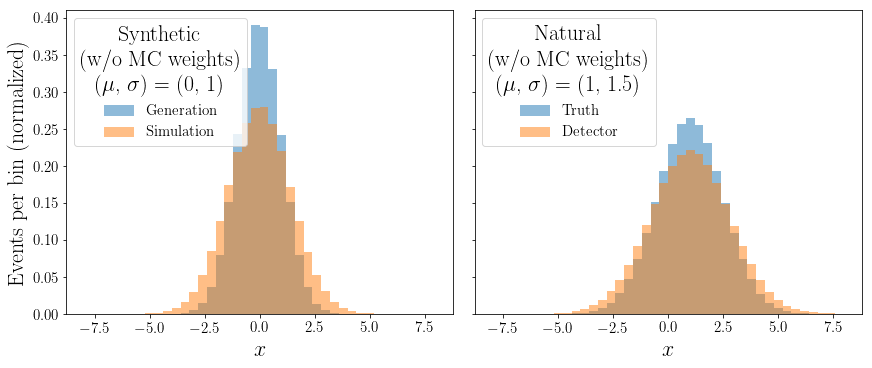

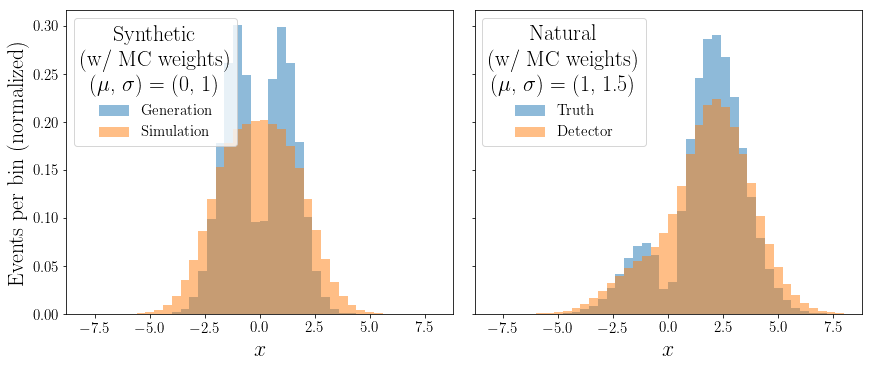

In [8]:
bins = np.linspace(-8, 8, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G, bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S, bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    title='Synthetic\n(w/o MC weights)\n($\mu$, $\sigma$) = {}'.format(
        theta0_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G, bins=bins, **plot_style_2, label='Truth')
ax[1].hist(theta_unknown_S, bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    title='Natural\n(w/o MC weights)\n($\mu$, $\sigma$) = {}'.format(
        theta_unknown_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G,
           weights=weightsMC_0,
           bins=bins,
           **plot_style_2,
           label='Generation')
ax[0].hist(theta0_S,
           weights=weightsMC_0,
           bins=bins,
           **plot_style_2,
           label='Simulation')
legend = ax[0].legend(
    title='Synthetic\n(w/ MC weights)\n($\mu$, $\sigma$) = {}'.format(
        theta0_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G,
           weights=weightsMC_unknown,
           bins=bins,
           **plot_style_2,
           label='Truth')
ax[1].hist(theta_unknown_S,
           weights=weightsMC_unknown,
           bins=bins,
           **plot_style_2,
           label='Detector')
legend = ax[1].legend(
    title='Natural\n(w/ MC weights)\n($\mu$, $\sigma$) = {}'.format(
        theta_unknown_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [9]:
iterations = 5

In [10]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((theta0_G, theta0_G))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [11]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(weights)

### Unfold without initial MC weights

In [12]:
# initial iterative weights are ones

weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [13]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1500000 samples, validate on 500000 samples
Epoch 1/200





1500000/1500000 [==============================] - 4s 3us/step - loss: 0.6432 - acc: 0.6222 - val_loss: 0.6376 - val_acc: 0.6293
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6365 - acc: 0.6307 - val_loss: 0.6374 - val_acc: 0.6293
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6363 - acc: 0.6309 - val_loss: 0.6373 - val_acc: 0.6293
Epoch 4/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6309 - val_loss: 0.6373 - val_acc: 0.6295
Epoch 5/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6363 - acc: 0.6310 - val_loss: 0.6373 - val_acc: 0.6294
Epoch 6/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6309 - val_loss:

Epoch 40/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6309 - val_loss: 0.6373 - val_acc: 0.6294
Epoch 41/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6309 - val_loss: 0.6372 - val_acc: 0.6293
Epoch 42/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6310 - val_loss: 0.6373 - val_acc: 0.6294
Epoch 43/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6309 - val_loss: 0.6373 - val_acc: 0.6294
Epoch 44/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6309 - val_loss: 0.6373 - val_acc: 0.6293
Restoring model weights from the end of the best epoch
Epoch 00044: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 4s 3us/step - loss: 0.6628 - acc: 0.5004 - val_loss: 0.6624 - val_acc: 0.4986
Epoc

Epoch 13/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6312 - acc: 0.5002 - val_loss: 0.6312 - val_acc: 0.4993
Epoch 14/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6311 - acc: 0.5002 - val_loss: 0.6312 - val_acc: 0.4994
Epoch 15/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6311 - acc: 0.5002 - val_loss: 0.6312 - val_acc: 0.4993
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 4s 3us/step - loss: 0.7009 - acc: 0.6052 - val_loss: 0.6879 - val_acc: 0.6141
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6889 - acc: 0.6022 - val_loss: 0.6879 - val_acc: 0.6066
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6889 - acc: 0.6017 - val_loss: 0.6880 - val_acc:

1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6916 - acc: 0.5716 - val_loss: 0.6902 - val_acc: 0.5432
Epoch 14/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6916 - acc: 0.5707 - val_loss: 0.6902 - val_acc: 0.5855
Epoch 15/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6917 - acc: 0.5701 - val_loss: 0.6902 - val_acc: 0.5907
Epoch 16/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6916 - acc: 0.5732 - val_loss: 0.6902 - val_acc: 0.5852
Epoch 17/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6916 - acc: 0.5712 - val_loss: 0.6905 - val_acc: 0.5680
Epoch 18/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6917 - acc: 0.5777 - val_loss: 0.6901 - val_acc: 0.5721
Epoch 19/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6917 - acc: 0.5686 - val_loss: 0.6901 - val_acc: 0.5912
Epoch 20/200
150000

Epoch 17/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6897 - acc: 0.5223 - val_loss: 0.6976 - val_acc: 0.5057
Epoch 18/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6897 - acc: 0.5223 - val_loss: 0.6968 - val_acc: 0.5802
Epoch 19/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6897 - acc: 0.5169 - val_loss: 0.6968 - val_acc: 0.5674
Restoring model weights from the end of the best epoch
Epoch 00019: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 4s 3us/step - loss: 0.6087 - acc: 0.4998 - val_loss: 0.5955 - val_acc: 0.5000
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5950 - acc: 0.5001 - val_loss: 0.5956 - val_acc: 0.5001
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5950 - acc: 0.5000 - val_loss: 0.5954 - val_acc: 0.4999
Epoch 

#### Step 1 Results (Simulation-level)

ITERATION 1:


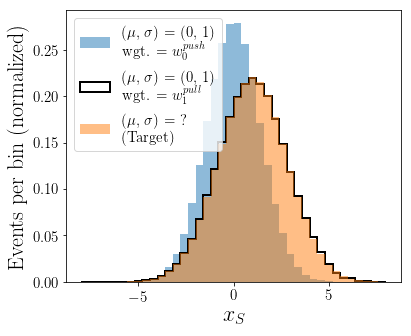

ITERATION 2:


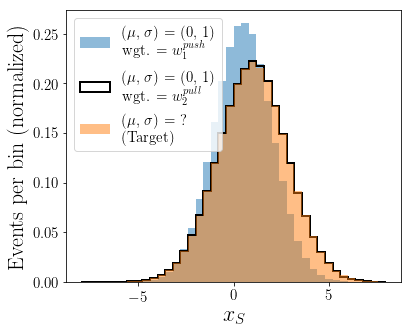

ITERATION 3:


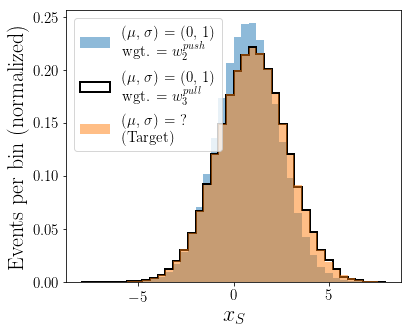

ITERATION 4:


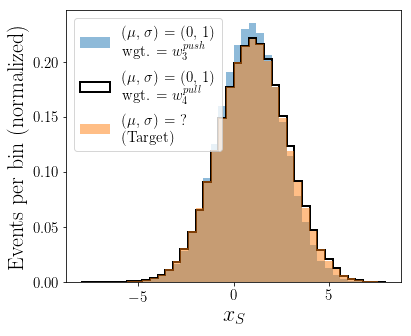

ITERATION 5:


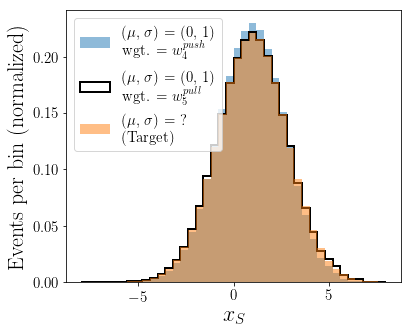

In [14]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    if i == 0:
        weights_init = np.ones(len(theta0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        theta0_S,
        weights=weights_init,
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nwgt. = $w_{}^{{push}}$'.format(
            theta0_param, '{' + str(i) + '}'),
        **plot_style_2)

    hist1 = plt.hist(
        theta0_S,
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nwgt. = $w_{}^{{pull}}$'.format(
            theta0_param, '{' + str(i + 1) + '}'),
        weights=weights[i, 0, :],
        **plot_style_1)
    hist2 = plt.hist(theta_unknown_S,
                     bins=bins,
                     label='($\mu$, $\sigma$) = ?\n(Target)',
                     **plot_style_2)
    plt.legend()
    plt.xlabel(r"$x_S$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION 1:


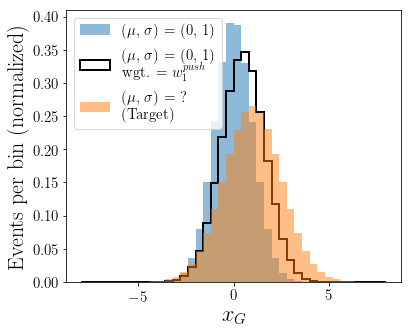

ITERATION 2:


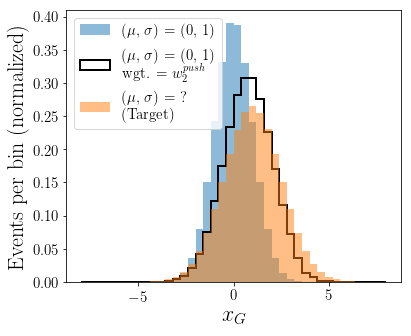

ITERATION 3:


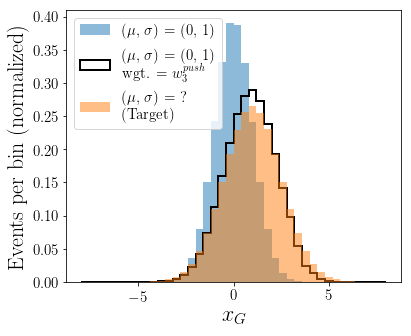

ITERATION 4:


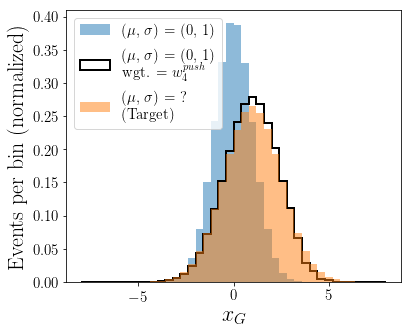

ITERATION 5:


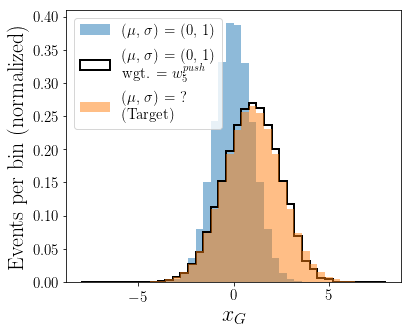

In [15]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(theta0_G,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    hist1 = plt.hist(
        theta0_G,
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nwgt. = $w_{}^{{push}}$'.format(
            theta0_param, '{' + str(i + 1) + '}'),
        weights=weights[i, 1, :],
        **plot_style_1)
    hist2 = plt.hist(theta_unknown_G,
                     bins=bins,
                     label='($\mu$, $\sigma$) = ?\n(Target)',
                     **plot_style_2)
    plt.legend()
    plt.xlabel(r"$x_G$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

### Unfold with initial MC weights

In [16]:
# increase number of iterations
iterations = 10

In [17]:
# initial iterative weights are MC weights

weights_pull = weightsMC_0
weights_push = weightsMC_0

In [18]:
# clear total weights

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

In [19]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, weightsMC_unknown))
    # actual weights for Sim., initial MC weights for Data

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((weightsMC_0, weights_pull))
    # initial MC weights for Gen., actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    # note we need to take into account MC weights when reweighting the synthetic gen.
    weights_push = weightsMC_0 * reweight(theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 4s 3us/step - loss: 0.6192 - acc: 0.6165 - val_loss: 0.6161 - val_acc: 0.6154
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6174 - acc: 0.6162 - val_loss: 0.6161 - val_acc: 0.6174
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6174 - acc: 0.6166 - val_loss: 0.6161 - val_acc: 0.6190
Epoch 4/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6174 - acc: 0.6169 - val_loss: 0.6160 - val_acc: 0.6180
Epoch 5/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6174 - acc: 0.6161 - val_loss: 0.6161 - val_acc: 0.6194
Epoch 6/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6174 - acc: 0.6169 - val_loss: 0.6160 - val_acc: 0.6168
Epoch 7/200
1500000/1500000 [==============================] - 3s 2us/step - l

1500000/1500000 [==============================] - 3s 2us/step - loss: 0.9586 - acc: 0.5950 - val_loss: 0.9620 - val_acc: 0.5957
Restoring model weights from the end of the best epoch
Epoch 00024: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 5s 3us/step - loss: 0.6171 - acc: 0.4998 - val_loss: 0.6046 - val_acc: 0.5007
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6034 - acc: 0.4997 - val_loss: 0.6046 - val_acc: 0.5008
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6033 - acc: 0.4997 - val_loss: 0.6046 - val_acc: 0.5007
Epoch 4/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6033 - acc: 0.4998 - val_loss: 0.6047 - val_acc: 0.5008
Epoch 5/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6033 - acc: 0.4999 - val_loss: 0.6046 - val_acc: 0.5006
Epoch 6/200
1500000/1

1500000/1500000 [==============================] - 5s 3us/step - loss: 1.0836 - acc: 0.5573 - val_loss: 0.9954 - val_acc: 0.5392
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0119 - acc: 0.5137 - val_loss: 0.9970 - val_acc: 0.5081
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0117 - acc: 0.5103 - val_loss: 0.9997 - val_acc: 0.5195
Epoch 4/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0111 - acc: 0.5201 - val_loss: 0.9969 - val_acc: 0.5328
Epoch 5/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0109 - acc: 0.5149 - val_loss: 0.9967 - val_acc: 0.5328
Epoch 6/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0110 - acc: 0.5127 - val_loss: 0.9960 - val_acc: 0.5183
Epoch 7/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0110 - acc: 0.5140 - val_loss: 1.0023 - val_acc: 0.4612
Epoch 8/200
1500000/15000

Epoch 17/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0351 - acc: 0.4874 - val_loss: 1.0151 - val_acc: 0.4387
Epoch 18/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0348 - acc: 0.4800 - val_loss: 1.0170 - val_acc: 0.4527
Epoch 19/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0350 - acc: 0.4728 - val_loss: 1.0141 - val_acc: 0.4466
Epoch 20/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0352 - acc: 0.4894 - val_loss: 1.0163 - val_acc: 0.5041
Restoring model weights from the end of the best epoch
Epoch 00020: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 5s 3us/step - loss: 0.6051 - acc: 0.5004 - val_loss: 0.5642 - val_acc: 0.4989
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5635 - acc: 0.5005 - val_loss: 0.5636 - val_acc: 0.4988
Epoch

Epoch 11/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5532 - acc: 0.5002 - val_loss: 0.5501 - val_acc: 0.4991
Epoch 12/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5532 - acc: 0.5002 - val_loss: 0.5504 - val_acc: 0.4991
Epoch 13/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5532 - acc: 0.5002 - val_loss: 0.5501 - val_acc: 0.4992
Epoch 14/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5532 - acc: 0.5003 - val_loss: 0.5501 - val_acc: 0.4991
Epoch 15/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5532 - acc: 0.5002 - val_loss: 0.5501 - val_acc: 0.4991
Epoch 16/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5532 - acc: 0.5002 - val_loss: 0.5500 - val_acc: 0.4992
Epoch 17/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5533 - acc: 0.5002 - val_loss: 0.5500 - val_acc: 0.4991
Epoch 

1500000/1500000 [==============================] - 5s 3us/step - loss: 1.0797 - acc: 0.5555 - val_loss: 1.0380 - val_acc: 0.5010
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0046 - acc: 0.4588 - val_loss: 1.0345 - val_acc: 0.5125
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0045 - acc: 0.5004 - val_loss: 1.0378 - val_acc: 0.5413
Epoch 4/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0047 - acc: 0.4884 - val_loss: 1.0434 - val_acc: 0.5072
Epoch 5/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0047 - acc: 0.5053 - val_loss: 1.0391 - val_acc: 0.5102
Epoch 6/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0046 - acc: 0.5110 - val_loss: 1.0356 - val_acc: 0.4016
Epoch 7/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0053 - acc: 0.4918 - val_loss: 1.0469 - val_acc: 0.4393
Epoch 8/200
1500000/15000

Epoch 9/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5543 - acc: 0.4998 - val_loss: 0.5555 - val_acc: 0.5006
Epoch 10/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5543 - acc: 0.4999 - val_loss: 0.5554 - val_acc: 0.5005
Epoch 11/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5543 - acc: 0.4998 - val_loss: 0.5553 - val_acc: 0.5009
Epoch 12/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5543 - acc: 0.4997 - val_loss: 0.5554 - val_acc: 0.5008
Epoch 13/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5543 - acc: 0.4998 - val_loss: 0.5558 - val_acc: 0.5006
Epoch 14/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5544 - acc: 0.4998 - val_loss: 0.5553 - val_acc: 0.5005
Restoring model weights from the end of the best epoch
Epoch 00014: early stopping

ITERATION: 10

STEP 1

Train on 1500000 samples, validate on 5000

1500000/1500000 [==============================] - 3s 2us/step - loss: 0.9916 - acc: 0.5441 - val_loss: 0.9903 - val_acc: 0.5019
Epoch 52/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.9916 - acc: 0.5090 - val_loss: 0.9899 - val_acc: 0.5420
Epoch 53/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.9913 - acc: 0.5286 - val_loss: 0.9896 - val_acc: 0.5518
Restoring model weights from the end of the best epoch
Epoch 00053: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 6s 4us/step - loss: 0.6116 - acc: 0.4996 - val_loss: 0.5489 - val_acc: 0.4997
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5500 - acc: 0.5002 - val_loss: 0.5484 - val_acc: 0.4994
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5498 - acc: 0.5001 - val_loss: 0.5483 - val_acc: 0.4993
Epoch 4/200
1500000

#### Step 1 Results (Simulation-level)

ITERATION 1:


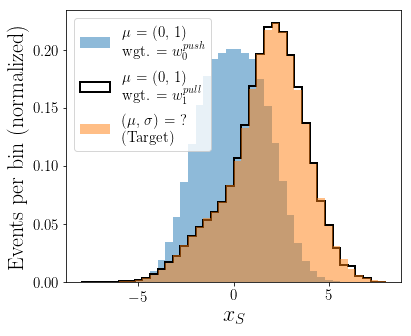

ITERATION 2:


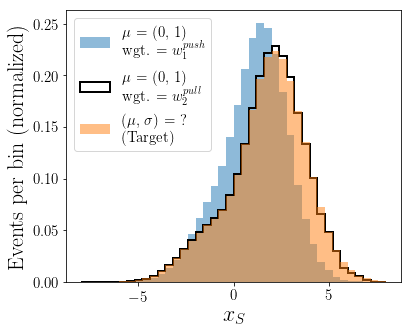

ITERATION 3:


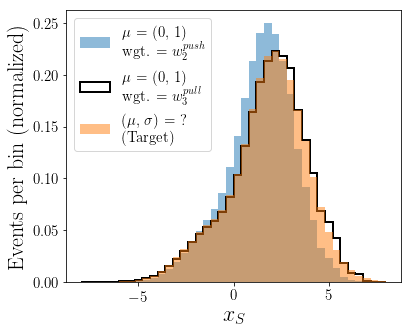

ITERATION 4:


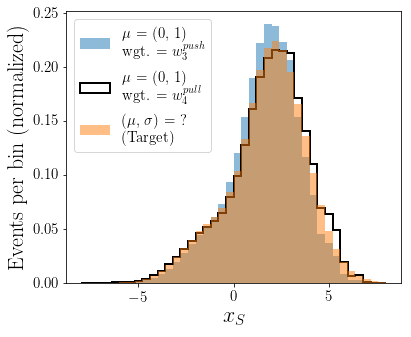

ITERATION 5:


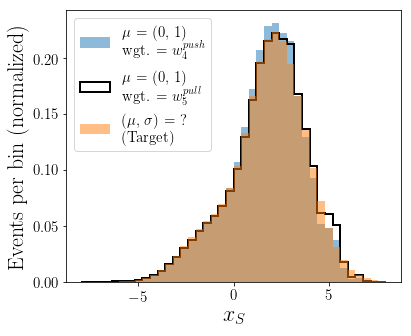

ITERATION 6:


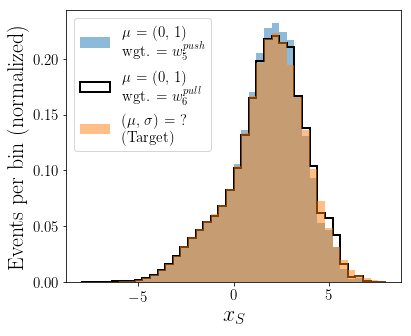

ITERATION 7:


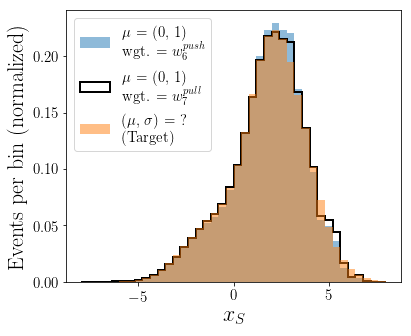

ITERATION 8:


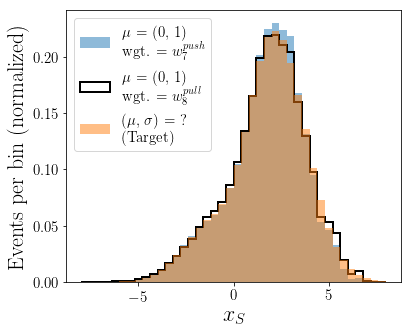

ITERATION 9:


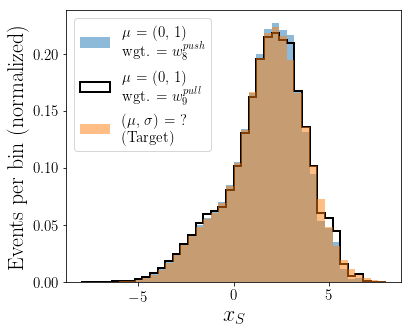

ITERATION 10:


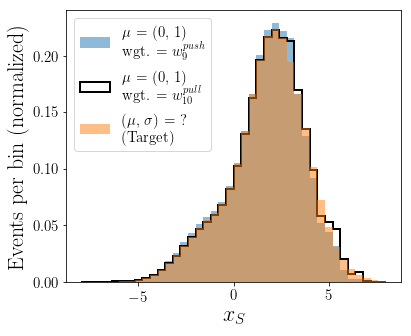

In [20]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    if i == 0:
        weights_init = weightsMC_0
    else:
        weights_init = weights[i - 1, 1, :]

    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(theta0_S,
                     weights=weights_init,
                     bins=bins,
                     label='$\mu$ = {}\nwgt. = $w_{}^{{push}}$'.format(
                         theta0_param, '{' + str(i) + '}'),
                     **plot_style_2)

    hist1 = plt.hist(theta0_S,
                     bins=bins,
                     label='$\mu$ = {}\nwgt. = $w_{}^{{pull}}$'.format(
                         theta0_param, '{' + str(i + 1) + '}'),
                     weights=weights[i, 0, :],
                     **plot_style_1)
    hist2 = plt.hist(theta_unknown_S,
                     weights=weightsMC_unknown,
                     bins=bins,
                     label='($\mu$, $\sigma$) = ?\n(Target)',
                     **plot_style_2)
    plt.legend()
    plt.xlabel(r"$x_S$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION 1:


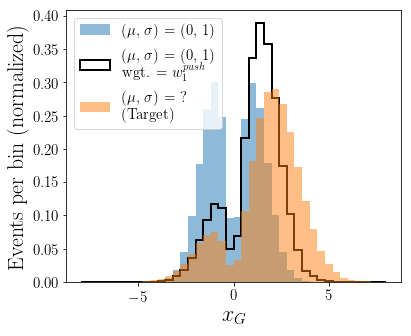

ITERATION 2:


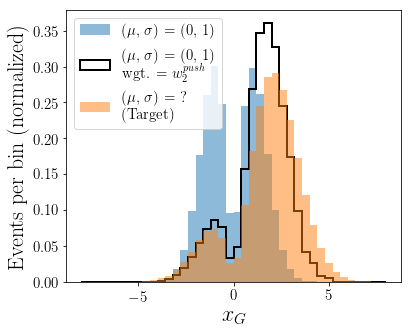

ITERATION 3:


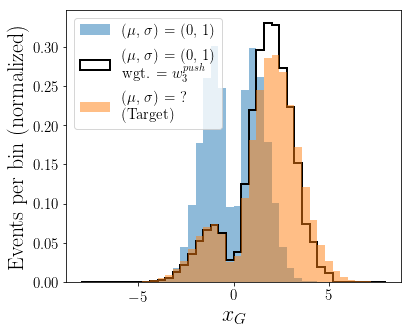

ITERATION 4:


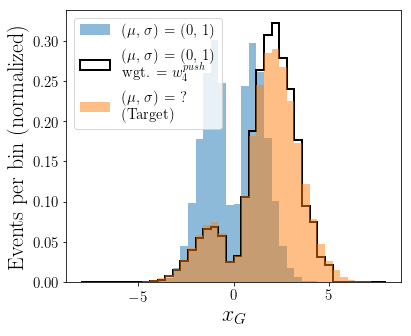

ITERATION 5:


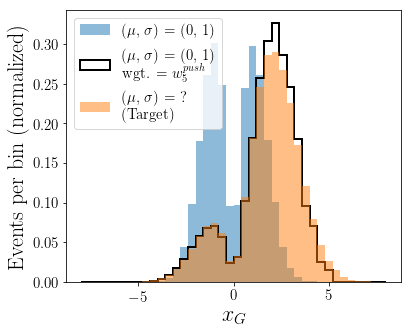

ITERATION 6:


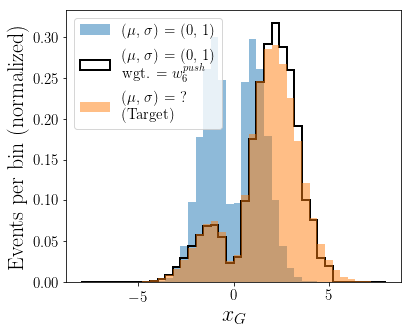

ITERATION 7:


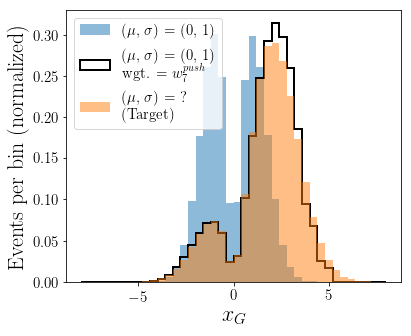

ITERATION 8:


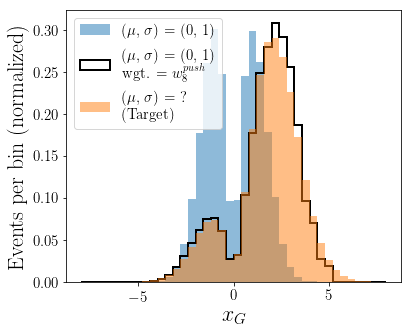

ITERATION 9:


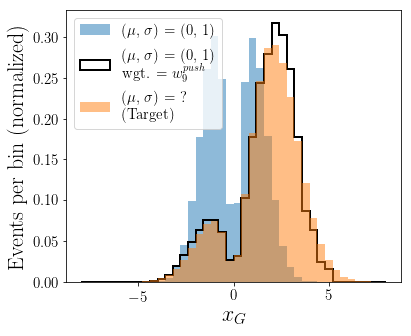

ITERATION 10:


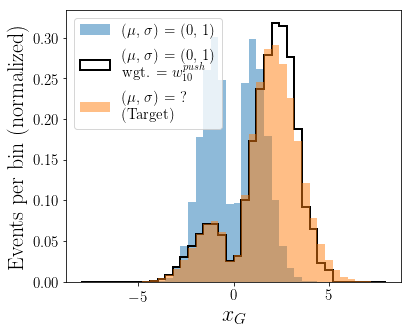

In [21]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(theta0_G,
                     weights=weightsMC_0,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    hist1 = plt.hist(
        theta0_G,
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nwgt. = $w_{}^{{push}}$'.format(
            theta0_param, '{' + str(i + 1) + '}'),
        weights=weights[i, 1, :],
        **plot_style_1)
    hist2 = plt.hist(theta_unknown_G,
                     weights=weightsMC_unknown,
                     bins=bins,
                     label='($\mu$, $\sigma$) = ?\n(Target)',
                     **plot_style_2)
    plt.legend()
    plt.xlabel(r"$x_G$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

## Unfold with Generator Parameter Dependent Detector Effects

In this example, we consider a two-dimensional generator feature space and a single dimensional simulation feature space. Specifically, we construct the detector response such that the simulation-level observable $X_S$ depends explicitly on the primary generator-level feature, but its detector smearing depends on the secondary generator-level feature. That is, detector effects are non-uniform, and are dependent on the generator-level parameter(s). In particular, we choose the primary generator-level feature $X_{G,0}\sim\mathcal{N}(\mu,1)$ and the secondary generator-level observable $X_{G,1}\sim\mathcal{N}(0,\nu^2)$, where  $\nu=(\omega_0 + \omega_1\mu)^2$ for two constants $\omega_0$ and $\omega_1$. (Specifically, we choose $\omega_0=0.7$ and $\omega_1=0.2$ for this example.) Then, on a per-event basis, detector effects are emulated by $X_S=X_{G,0}+Z$, where $Z\sim\mathcal{N}(4\lvert x_{G,1}\rvert,(x_{G,1})^4)$, and $4\lvert x_{G,1}\rvert$ represents a net shift bias and $(x_{G,1})^2$ represents a smearing bias. Importantly, the resolution depends on the secondary generator-level feature.

## Setup the Datasets

In [22]:
def nu(theta, omega_0=0.7, omega_1=0.2):
    return (omega_0 + omega_1 * theta)**2

In [23]:
N = 10**6

theta0_param = mu0  # synthetic sample
theta_unknown_param = 1.5  # this is the data (the target)

theta0_G_0 = np.random.normal(theta0_param, 1, N)
theta0_G_1 = np.random.normal(0, nu(theta0_param), N)
theta0_G = np.stack((theta0_G_0, theta0_G_1), axis=-1)

theta0_S = np.array([(x[0] + np.random.normal(4 * abs(x[1]), x[1]**2))
                     for x in theta0_G])  # Detector smearing

labels0 = np.zeros(len(theta0_G))

theta_unknown_G_0 = np.random.normal(theta_unknown_param, 1, N)
theta_unknown_G_1 = np.random.normal(0, nu(theta_unknown_param), N)
theta_unknown_G = np.stack((theta_unknown_G_0, theta_unknown_G_1), axis=-1)

theta_unknown_S = np.array([(x[0] + np.random.normal(4 * abs(x[1]), x[1]**2))
                            for x in theta_unknown_G])  # Detector smearing

labels_unknown = np.ones(len(theta_unknown_S))

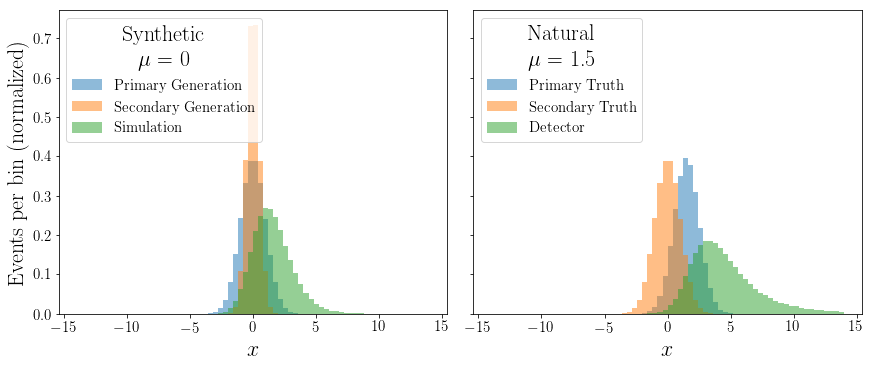

In [24]:
bins = np.linspace(-14, 14, 71)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[:, 0],
           bins=bins,
           **plot_style_2,
           label='Primary Generation')
ax[0].hist(theta0_G[:, 1],
           bins=bins,
           **plot_style_2,
           label='Secondary Generation')
ax[0].hist(theta0_S, bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(title='Synthetic\n$\mu$ = {}'.format(theta0_param),
                      loc='upper left',
                      frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G[:, 0],
           bins=bins,
           **plot_style_2,
           label='Primary Truth')
ax[1].hist(theta_unknown_G[:, 1],
           bins=bins,
           **plot_style_2,
           label='Secondary Truth')
ax[1].hist(theta_unknown_S, bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(title='Natural\n$\mu$ = {}'.format(theta_unknown_param),
                      loc='upper left',
                      frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

### Unfold

In [25]:
iterations = 10

In [26]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((theta0_G, theta0_G))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0_G)))
# shape = (iteration, step, event)

# Seperate models for Gen. and Sim. due to different feature spaces
inputs_G = Input((2, ))
hidden_layer_1_G = Dense(50, activation='relu')(inputs_G)
hidden_layer_2_G = Dense(50, activation='relu')(hidden_layer_1_G)
hidden_layer_3_G = Dense(50, activation='relu')(hidden_layer_2_G)
outputs_G = Dense(1, activation='sigmoid')(hidden_layer_3_G)

model_G = Model(inputs=inputs_G, outputs=outputs_G)

inputs_S = Input((1, ))
hidden_layer_1_S = Dense(50, activation='relu')(inputs_S)
hidden_layer_2_S = Dense(50, activation='relu')(hidden_layer_1_S)
hidden_layer_3_S = Dense(50, activation='relu')(hidden_layer_2_S)
outputs_S = Dense(1, activation='sigmoid')(hidden_layer_3_S)

model_S = Model(inputs=inputs_S, outputs=outputs_S)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [27]:
# from NN (DCTR)
def reweight(model, events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(weights)

In [28]:
# initial iterative weights are ones

weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [29]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model_S.compile(loss='binary_crossentropy',
                    optimizer='Adam',
                    metrics=['accuracy'])
    model_S.fit(X_train_1,
                Y_train_1,
                sample_weight=w_train_1,
                epochs=200,
                batch_size=10000,
                validation_data=(X_test_1, Y_test_1, w_test_1),
                callbacks=[earlystopping],
                verbose=1)

    weights_pull = weights_push * reweight(model_S, theta0_S)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model_G.compile(loss='binary_crossentropy',
                    optimizer='Adam',
                    metrics=['accuracy'])
    model_G.fit(X_train_2,
                Y_train_2,
                sample_weight=w_train_2,
                epochs=200,
                batch_size=10000,
                validation_data=(X_test_2, Y_test_2, w_test_2),
                callbacks=[earlystopping],
                verbose=1)

    weights_push = reweight(model_G, theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 6s 4us/step - loss: 0.5177 - acc: 0.7315 - val_loss: 0.4825 - val_acc: 0.7651
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4792 - acc: 0.7660 - val_loss: 0.4801 - val_acc: 0.7652
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4782 - acc: 0.7662 - val_loss: 0.4802 - val_acc: 0.7652
Epoch 4/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4780 - acc: 0.7662 - val_loss: 0.4799 - val_acc: 0.7652
Epoch 5/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4781 - acc: 0.7663 - val_loss: 0.4798 - val_acc: 0.7654
Epoch 6/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4781 - acc: 0.7663 - val_loss: 0.4799 - val_acc: 0.7652
Epoch 7/200
1500000/1500000 [==============================] - 3s 2us/step - l

1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6888 - acc: 0.6320 - val_loss: 0.6810 - val_acc: 0.6531
Epoch 18/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6888 - acc: 0.6312 - val_loss: 0.6812 - val_acc: 0.6572
Epoch 19/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6888 - acc: 0.6330 - val_loss: 0.6830 - val_acc: 0.5911
Epoch 20/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6887 - acc: 0.6316 - val_loss: 0.6814 - val_acc: 0.6187
Epoch 21/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6887 - acc: 0.6346 - val_loss: 0.6814 - val_acc: 0.6181
Epoch 22/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6886 - acc: 0.6300 - val_loss: 0.6813 - val_acc: 0.6296
Epoch 23/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6886 - acc: 0.6312 - val_loss: 0.6811 - val_acc: 0.6499
Epoch 24/200
150000

Epoch 9/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6964 - acc: 0.5127 - val_loss: 0.6960 - val_acc: 0.5978
Epoch 10/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6965 - acc: 0.4952 - val_loss: 0.6961 - val_acc: 0.5522
Epoch 11/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6961 - acc: 0.4978 - val_loss: 0.6957 - val_acc: 0.5714
Epoch 12/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6962 - acc: 0.4855 - val_loss: 0.6959 - val_acc: 0.5901
Restoring model weights from the end of the best epoch
Epoch 00012: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 6s 4us/step - loss: 0.4511 - acc: 0.5001 - val_loss: 0.4517 - val_acc: 0.4995
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4511 - acc: 0.5001 - val_loss: 0.4517 - val_acc: 0.4995
Epoch 

Epoch 8/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4565 - acc: 0.5001 - val_loss: 0.4571 - val_acc: 0.4995
Epoch 9/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4564 - acc: 0.5003 - val_loss: 0.4569 - val_acc: 0.4994
Epoch 10/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4564 - acc: 0.5002 - val_loss: 0.4570 - val_acc: 0.4993
Epoch 11/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4564 - acc: 0.5002 - val_loss: 0.4570 - val_acc: 0.4994
Epoch 12/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4565 - acc: 0.5003 - val_loss: 0.4569 - val_acc: 0.4994
Epoch 13/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4564 - acc: 0.5003 - val_loss: 0.4570 - val_acc: 0.4994
Epoch 14/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4564 - acc: 0.5002 - val_loss: 0.4569 - val_acc: 0.4993
Epoch 15

1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6789 - acc: 0.3623 - val_loss: 0.6822 - val_acc: 0.4237
Epoch 6/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6789 - acc: 0.3786 - val_loss: 0.6815 - val_acc: 0.3843
Epoch 7/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6789 - acc: 0.4106 - val_loss: 0.6813 - val_acc: 0.3942
Epoch 8/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6793 - acc: 0.4251 - val_loss: 0.6813 - val_acc: 0.3235
Epoch 9/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6789 - acc: 0.3933 - val_loss: 0.6820 - val_acc: 0.4288
Epoch 10/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6793 - acc: 0.4411 - val_loss: 0.6816 - val_acc: 0.3904
Epoch 11/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6791 - acc: 0.3890 - val_loss: 0.6814 - val_acc: 0.4039
Epoch 12/200
1500000/15

Epoch 9/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4487 - acc: 0.5000 - val_loss: 0.4477 - val_acc: 0.4998
Epoch 10/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4488 - acc: 0.5000 - val_loss: 0.4478 - val_acc: 0.4999
Epoch 11/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4488 - acc: 0.5001 - val_loss: 0.4476 - val_acc: 0.4999
Epoch 12/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4488 - acc: 0.5000 - val_loss: 0.4476 - val_acc: 0.4999
Restoring model weights from the end of the best epoch
Epoch 00012: early stopping

ITERATION: 8

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 7s 5us/step - loss: 0.6735 - acc: 0.5466 - val_loss: 0.6711 - val_acc: 0.6755
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6738 - acc: 0.6186 - val_loss: 0.6707 - val_acc:

1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6889 - acc: 0.4527 - val_loss: 0.6799 - val_acc: 0.5221
Restoring model weights from the end of the best epoch
Epoch 00019: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 7s 5us/step - loss: 0.4505 - acc: 0.5004 - val_loss: 0.4509 - val_acc: 0.4987
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4505 - acc: 0.5003 - val_loss: 0.4510 - val_acc: 0.4987
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4504 - acc: 0.5005 - val_loss: 0.4511 - val_acc: 0.4987
Epoch 4/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4505 - acc: 0.5004 - val_loss: 0.4508 - val_acc: 0.4989
Epoch 5/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.4504 - acc: 0.5003 - val_loss: 0.4512 - val_acc: 0.4986
Epoch 6/200
1500000/1

#### Step 1 Results (Simulation-level)

ITERATION 1:


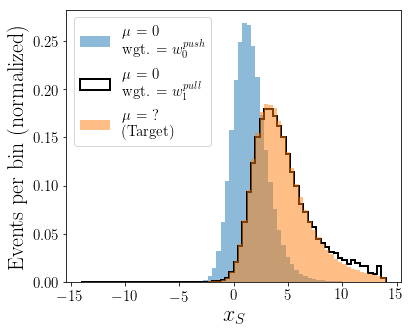

ITERATION 2:


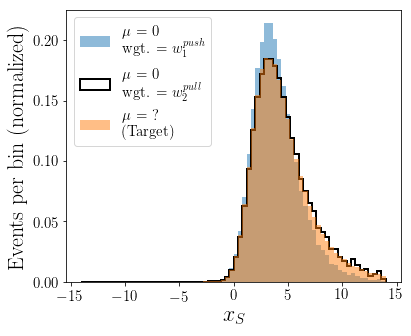

ITERATION 3:


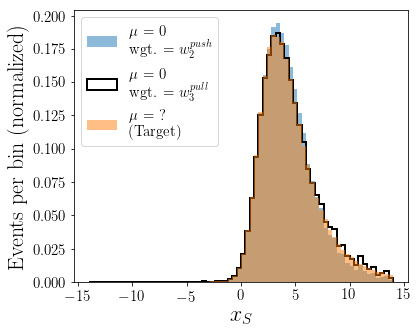

ITERATION 4:


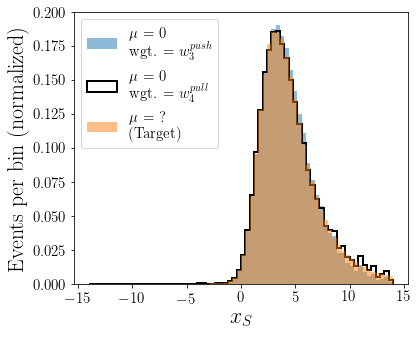

ITERATION 5:


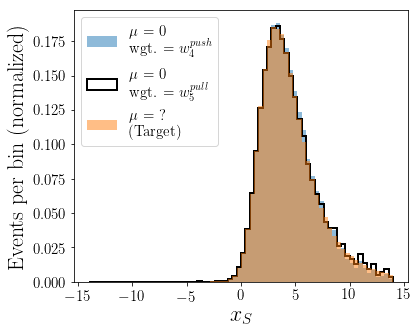

ITERATION 6:


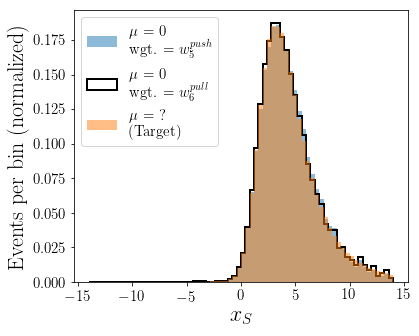

ITERATION 7:


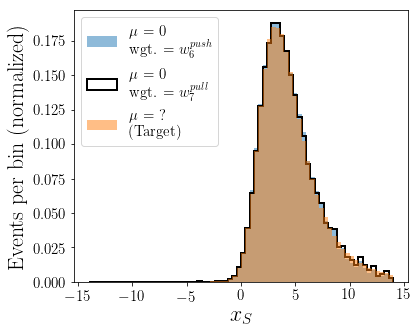

ITERATION 8:


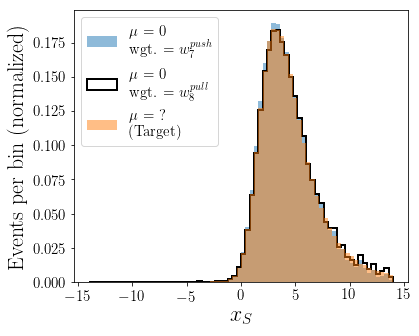

ITERATION 9:


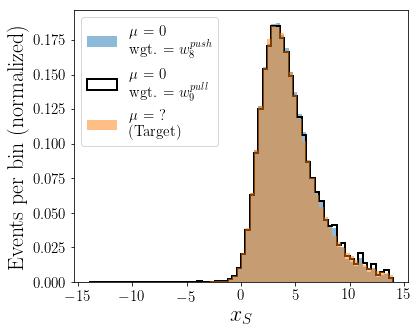

ITERATION 10:


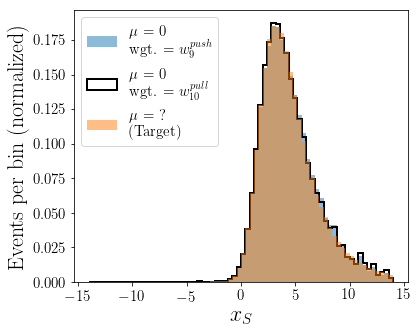

In [30]:
bins = np.linspace(-14, 14, 71)

for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    if i == 0:
        weights_init = np.ones(len(theta0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(theta0_S,
                     bins=bins,
                     weights=weights_init,
                     label='$\mu$ = {}\nwgt. = $w_{}^{{push}}$'.format(
                         theta0_param, '{' + str(i) + '}'),
                     **plot_style_2)

    hist1 = plt.hist(theta0_S,
                     bins=bins,
                     label='$\mu$ = {}\nwgt. = $w_{}^{{pull}}$'.format(
                         theta0_param, '{' + str(i + 1) + '}'),
                     weights=weights[i, 0, :],
                     **plot_style_1)
    hist2 = plt.hist(theta_unknown_S,
                     bins=bins,
                     label='$\mu$ = ?\n(Target)',
                     **plot_style_2)
    plt.legend()
    plt.xlabel(r"$x_S$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION 1:


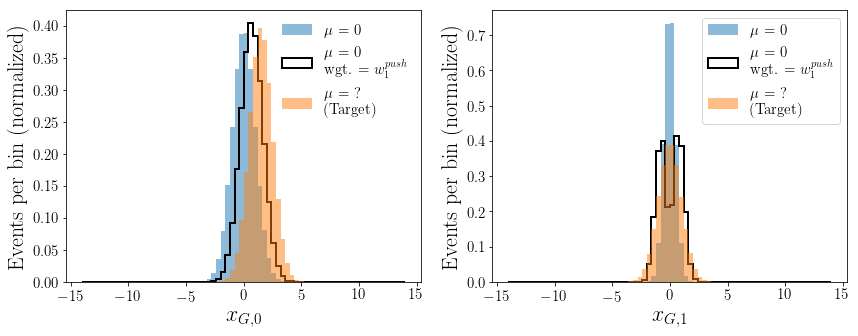

ITERATION 2:


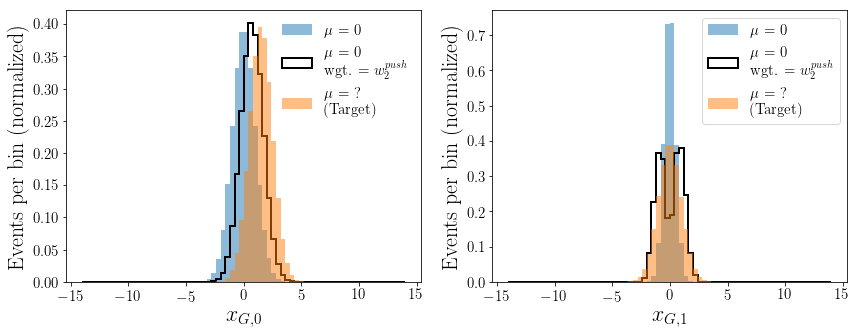

ITERATION 3:


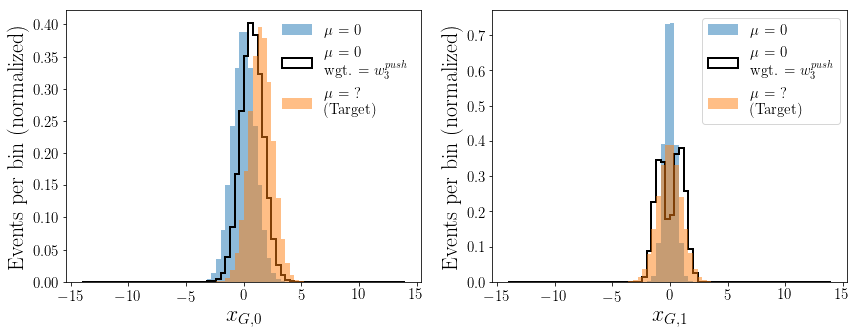

ITERATION 4:


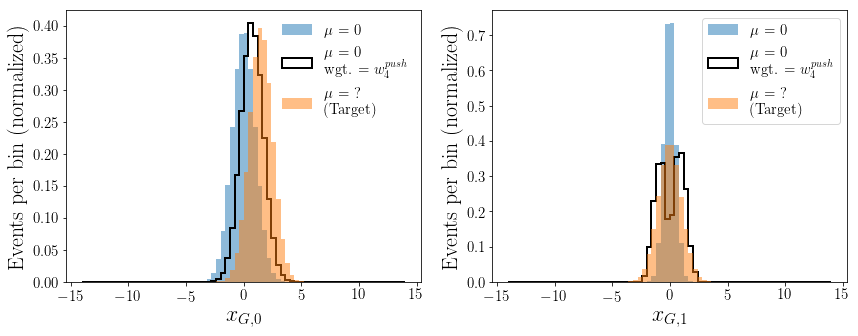

ITERATION 5:


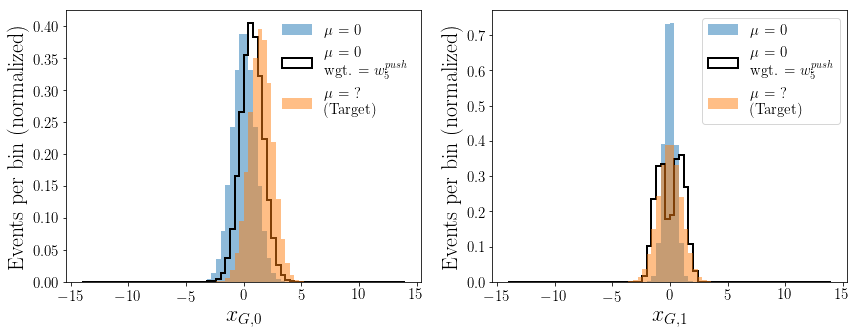

ITERATION 6:


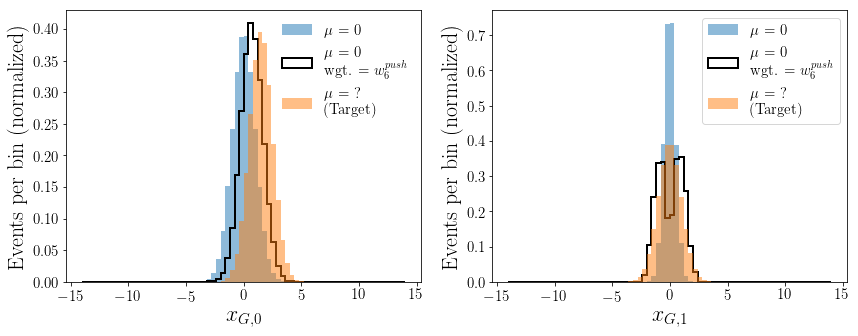

ITERATION 7:


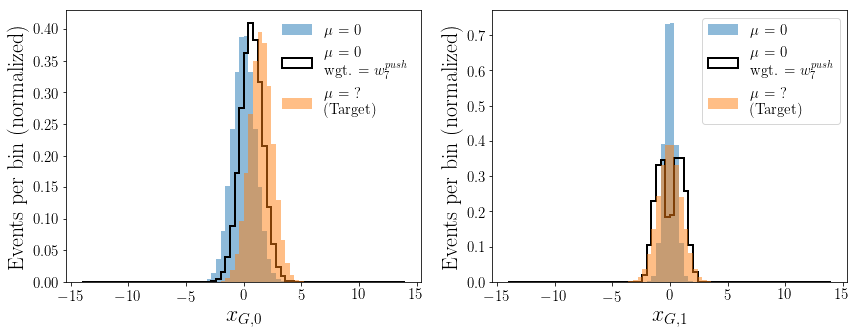

ITERATION 8:


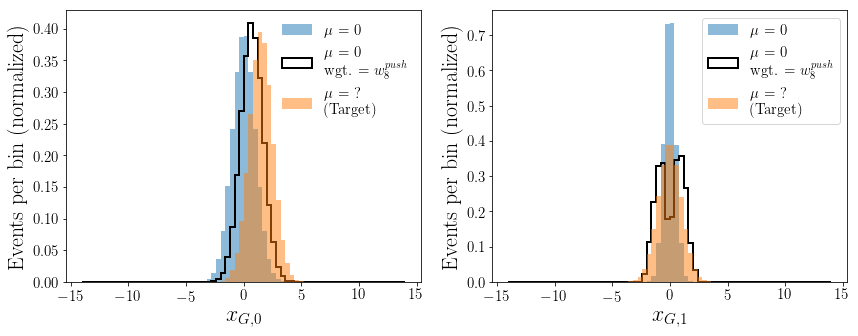

ITERATION 9:


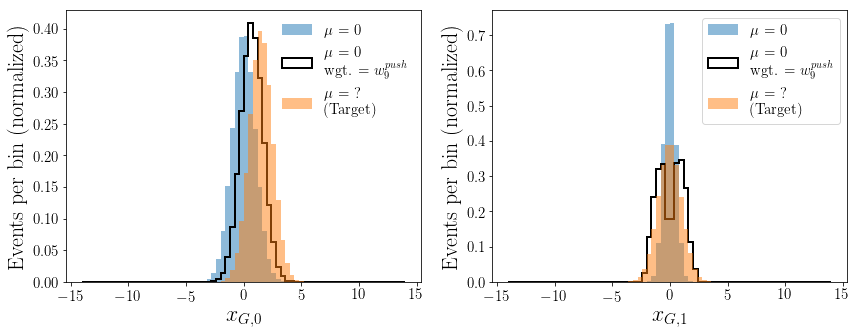

ITERATION 10:


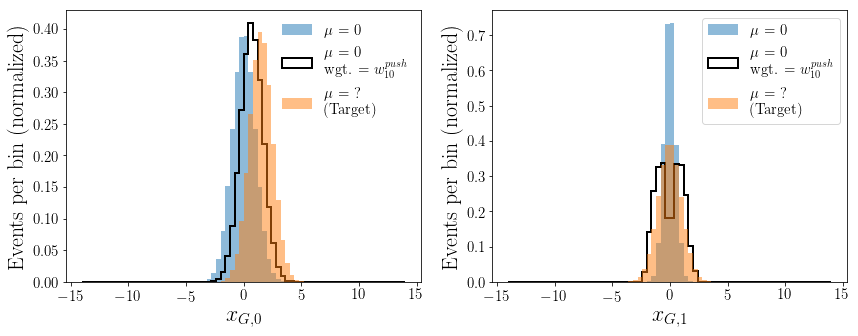

In [31]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].hist(theta0_G[:, 0],
               bins=bins,
               label=r'$\mu$ = {}'.format(theta0_param),
               **plot_style_2)
    ax[0].hist(theta0_G[:, 0],
               bins=bins,
               label='$\mu$ = {}\nwgt. = $w_{}^{{push}}$'.format(
                   theta0_param, '{' + str(i + 1) + '}'),
               weights=weights[i, 1, :],
               **plot_style_1)
    ax[0].hist(theta_unknown_G[:, 0],
               bins=bins,
               label='$\mu$ = ?\n(Target)',
               **plot_style_2)
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_{G,0}$")
    ax[0].set_ylabel("Events per bin (normalized)")

    ax[1].hist(theta0_G[:, 1],
               bins=bins,
               label=r'$\mu$ = {}'.format(theta0_param),
               **plot_style_2)
    ax[1].hist(theta0_G[:, 1],
               bins=bins,
               label='$\mu$ = {}\nwgt. = $w_{}^{{push}}$'.format(
                   theta0_param, '{' + str(i + 1) + '}'),
               weights=weights[i, 1, :],
               **plot_style_1)
    ax[1].hist(theta_unknown_G[:, 1],
               bins=bins,
               label='$\mu$ = ?\n(Target)',
               **plot_style_2)
    ax[1].legend()
    ax[1].set_xlabel(r"$x_{G,1}$")
    ax[1].set_ylabel("Events per bin (normalized)")
    plt.show()
    fig.show()